# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_loss, ab_physics_loss
from Preprocessing import random_spatial_sequence, collate_fn, collate_insitu_validation

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': True,
    'test_ratio': 0.2,
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 71*2, 
    'valid_batch_size': 78,
    'test_batch_size': 1,
    'sim_threshold': 0.8,
    'learning_rate': 5e-4,
    'step_size': 15,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 200,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
# 创建数据集
dataset = SMAPDataset(config['root'])

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID
***************************Load data path******************************
valid day sequence: ['2015091', '2015104', '2015106', '2015114', '2015115', '2015117', '2015128', '2015130', '2015131', '2015136', '2015138', '2015141', '2015149', '2015154', '2015157', '2015160', '2015162', '2015163', '2015165', '2015171', '2015176', '2015186', '2015187', '2015189', '2015194', '2015195', '2015197', '2015200', '2015202', '2015203', '2015205', '2015208', '2015211', '2015213', '2015216', '2015221', '2015226', '2015229', '2015232', '2015234', '2015235', '2015237', '2015242', '2015243', '2015258', '2015259', '2015261', '2015267', '2015272', '2015275', '2015277', '2015280', '2015282', '2015283', '2015285', '2015288', '2015290', '2015291', '2015296', '2015325', '2015330', '2015333']
_______________________________2015091_______________________________
_______________________________2015104__________________________

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015226\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015226\32.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015226\32.npy
_____________________________smap cell: 33_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015226\33.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\33.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015226\33.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015226\33.npy
_____________________________smap cell: 34_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015291\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015291\20.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015291\20.npy
_____________________________smap cell: 21_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015291\21.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\21.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015291\21.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015291\21.npy
_____________________________smap cell: 22_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_

In [6]:
# 计算训练集和测试集的长度
train_len = int(len(dataset) * (1-config['test_ratio']))
test_len = len(dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_fn)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 710
validing size 78
testing size 197


# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_loss 
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        if epoch==10:
            config['sim_threshold'] = 0.93
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               
            pred = model(x)
            relu(pred[:, 0])
#             print(pred)
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Training', config['sim_threshold'])
            loss = physical_loss + sim_loss
            loss.backward()                     
            optimizer.step()                   
            step += 1
            
            physical_loss_record.append(physical_loss.detach().item())
            sim_loss_record.append(sim_loss.detach().item())
            loss_record.append(loss.detach().item())
         
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() 
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
                relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
                physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
                loss = physical_loss + sim_loss
            
            physical_loss_record.append(physical_loss.item())
            sim_loss_record.append(sim_loss.item())
            loss_record.append(loss.item())

        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_valid_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || Train physical loss: {mean_train_physical_loss:.4f} || Train similarity loss: {mean_train_sim_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || Valid physical loss: {mean_valid_physical_loss:.4f} || Valid similarity loss: {mean_valid_sim_loss:.4f}')
            
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'first'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'last'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Start training!

(11, 11, 19)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


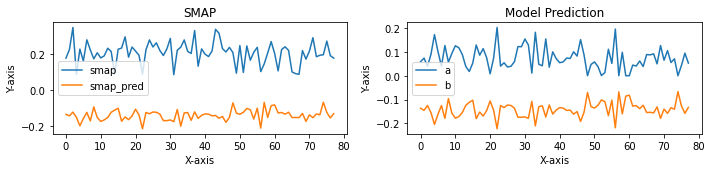

Epoch [1/5000] (LR: 0.0005):
Train loss: 1.5204 || Train physical loss: 0.1210 || Train similarity loss: 1.3994
Valid loss: 1.5570 || Valid physical loss: 0.1243 || Valid similarity loss: 1.4327
Saving model with loss 1.557...


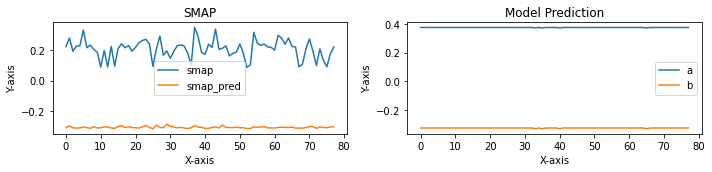

Epoch [2/5000] (LR: 0.0005):
Train loss: 1.4642 || Train physical loss: 0.1024 || Train similarity loss: 1.3617
Valid loss: 1.7702 || Valid physical loss: 0.2707 || Valid similarity loss: 1.4994


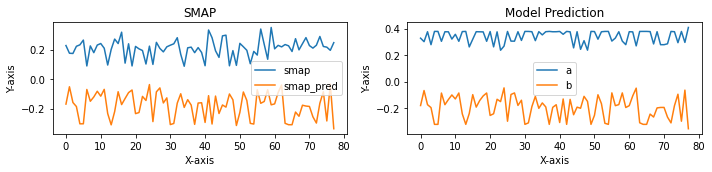

Epoch [3/5000] (LR: 0.0005):
Train loss: 1.2099 || Train physical loss: 0.1029 || Train similarity loss: 1.1069
Valid loss: 1.5701 || Valid physical loss: 0.1616 || Valid similarity loss: 1.4085


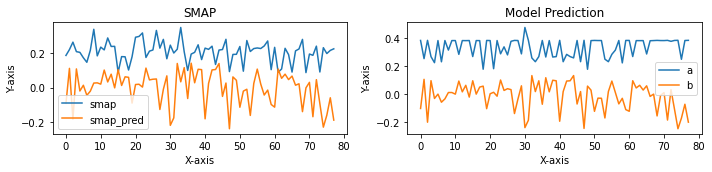

Epoch [4/5000] (LR: 0.0005):
Train loss: 0.9322 || Train physical loss: 0.0907 || Train similarity loss: 0.8415
Valid loss: 1.4413 || Valid physical loss: 0.0583 || Valid similarity loss: 1.3830
Saving model with loss 1.441...


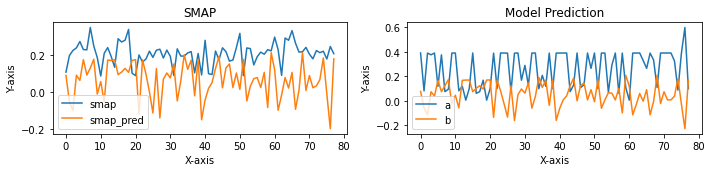

Epoch [5/5000] (LR: 0.0005):
Train loss: 1.3009 || Train physical loss: 0.0310 || Train similarity loss: 1.2700
Valid loss: 1.3443 || Valid physical loss: 0.0345 || Valid similarity loss: 1.3098
Saving model with loss 1.344...


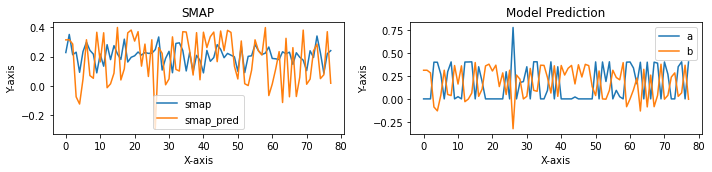

Epoch [6/5000] (LR: 0.0005):
Train loss: 1.2819 || Train physical loss: 0.0416 || Train similarity loss: 1.2403
Valid loss: 1.2812 || Valid physical loss: 0.0305 || Valid similarity loss: 1.2507
Saving model with loss 1.281...


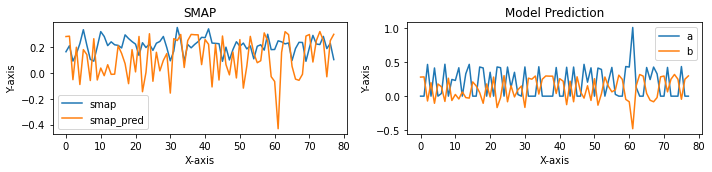

Epoch [7/5000] (LR: 0.0005):
Train loss: 1.1905 || Train physical loss: 0.0471 || Train similarity loss: 1.1434
Valid loss: 1.2736 || Valid physical loss: 0.0367 || Valid similarity loss: 1.2370
Saving model with loss 1.274...


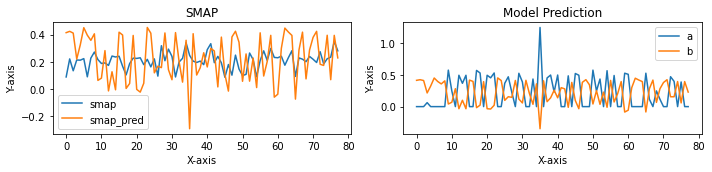

Epoch [8/5000] (LR: 0.0005):
Train loss: 0.6141 || Train physical loss: 0.0418 || Train similarity loss: 0.5723
Valid loss: 0.4470 || Valid physical loss: 0.0326 || Valid similarity loss: 0.4144
Saving model with loss 0.447...


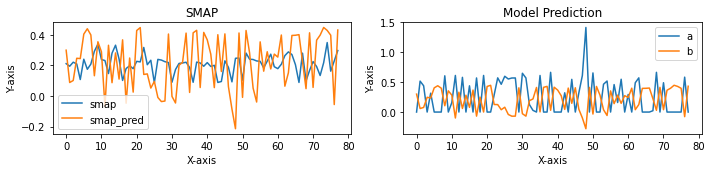

Epoch [9/5000] (LR: 0.0005):
Train loss: 0.4489 || Train physical loss: 0.0407 || Train similarity loss: 0.4082
Valid loss: 0.4451 || Valid physical loss: 0.0333 || Valid similarity loss: 0.4118
Saving model with loss 0.445...


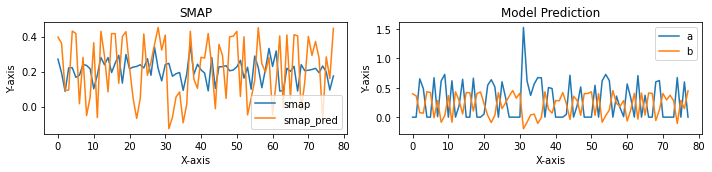

Epoch [10/5000] (LR: 0.0005):
Train loss: 0.4472 || Train physical loss: 0.0372 || Train similarity loss: 0.4100
Valid loss: 0.4444 || Valid physical loss: 0.0338 || Valid similarity loss: 0.4105
Saving model with loss 0.444...


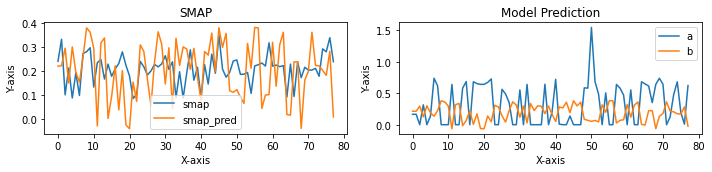

Epoch [11/5000] (LR: 0.0005):
Train loss: 0.0299 || Train physical loss: 0.0299 || Train similarity loss: 0.0000
Valid loss: 0.0165 || Valid physical loss: 0.0165 || Valid similarity loss: 0.0000
Saving model with loss 0.016...


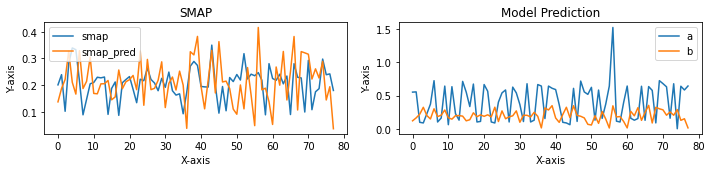

Epoch [12/5000] (LR: 0.0005):
Train loss: 0.0118 || Train physical loss: 0.0118 || Train similarity loss: 0.0000
Valid loss: 0.0096 || Valid physical loss: 0.0096 || Valid similarity loss: 0.0000
Saving model with loss 0.010...


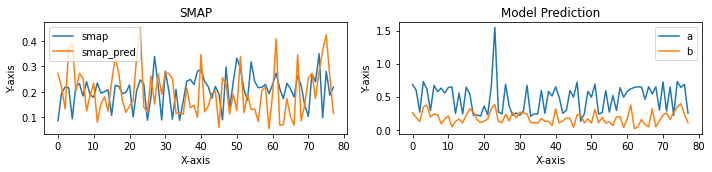

Epoch [13/5000] (LR: 0.0005):
Train loss: 0.0106 || Train physical loss: 0.0106 || Train similarity loss: 0.0000
Valid loss: 0.0119 || Valid physical loss: 0.0119 || Valid similarity loss: 0.0000


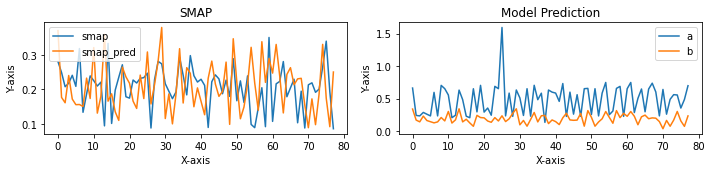

Epoch [14/5000] (LR: 0.0005):
Train loss: 0.0106 || Train physical loss: 0.0106 || Train similarity loss: 0.0000
Valid loss: 0.0080 || Valid physical loss: 0.0080 || Valid similarity loss: 0.0000
Saving model with loss 0.008...


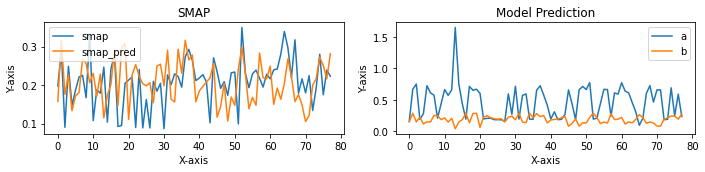

Epoch [15/5000] (LR: 0.0005):
Train loss: 0.0066 || Train physical loss: 0.0066 || Train similarity loss: 0.0000
Valid loss: 0.0057 || Valid physical loss: 0.0057 || Valid similarity loss: 0.0000
Saving model with loss 0.006...


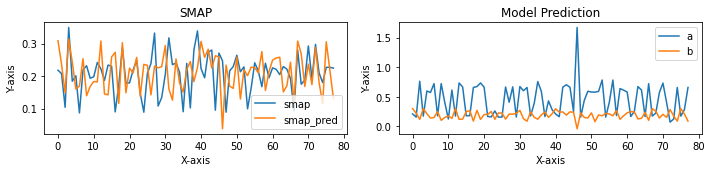

Epoch [16/5000] (LR: 0.0005):
Train loss: 0.0056 || Train physical loss: 0.0056 || Train similarity loss: 0.0000
Valid loss: 0.0059 || Valid physical loss: 0.0059 || Valid similarity loss: 0.0000


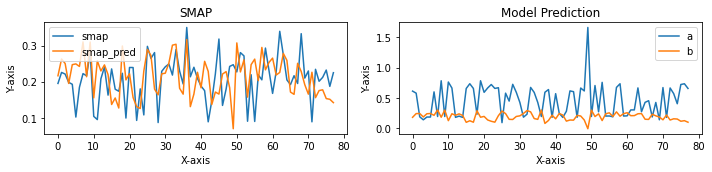

Epoch [17/5000] (LR: 0.0005):
Train loss: 0.0057 || Train physical loss: 0.0057 || Train similarity loss: 0.0000
Valid loss: 0.0053 || Valid physical loss: 0.0053 || Valid similarity loss: 0.0000
Saving model with loss 0.005...


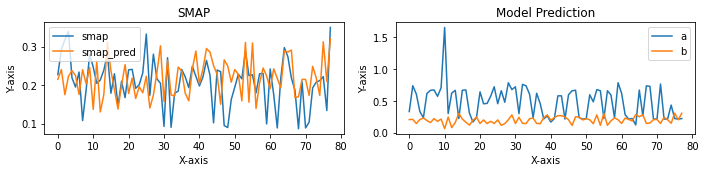

Epoch [18/5000] (LR: 0.0005):
Train loss: 0.1000 || Train physical loss: 0.0048 || Train similarity loss: 0.0952
Valid loss: 0.0047 || Valid physical loss: 0.0047 || Valid similarity loss: 0.0000
Saving model with loss 0.005...


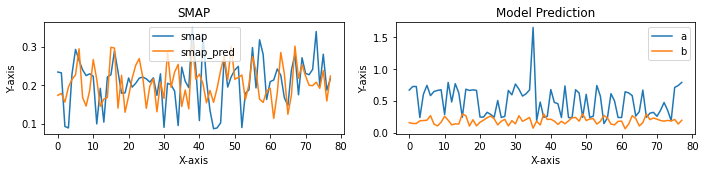

Epoch [19/5000] (LR: 0.0005):
Train loss: 0.0996 || Train physical loss: 0.0046 || Train similarity loss: 0.0950
Valid loss: 0.0045 || Valid physical loss: 0.0045 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


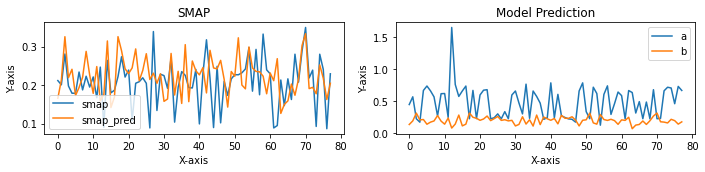

Epoch [20/5000] (LR: 0.0005):
Train loss: 0.0997 || Train physical loss: 0.0044 || Train similarity loss: 0.0953
Valid loss: 0.0048 || Valid physical loss: 0.0048 || Valid similarity loss: 0.0000


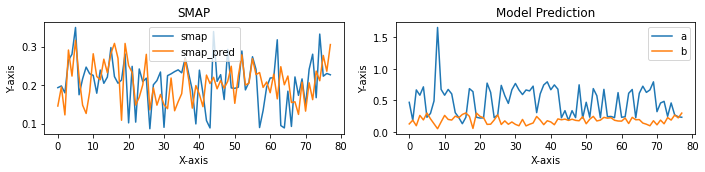

Epoch [21/5000] (LR: 0.0005):
Train loss: 0.0998 || Train physical loss: 0.0047 || Train similarity loss: 0.0951
Valid loss: 0.0046 || Valid physical loss: 0.0046 || Valid similarity loss: 0.0000


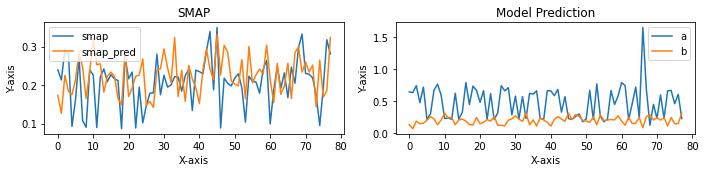

Epoch [22/5000] (LR: 0.0005):
Train loss: 0.0045 || Train physical loss: 0.0045 || Train similarity loss: 0.0000
Valid loss: 0.0048 || Valid physical loss: 0.0048 || Valid similarity loss: 0.0000


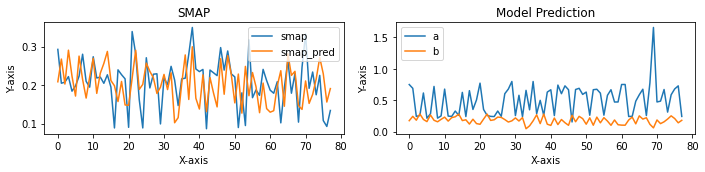

Epoch [23/5000] (LR: 0.0005):
Train loss: 0.0993 || Train physical loss: 0.0042 || Train similarity loss: 0.0951
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


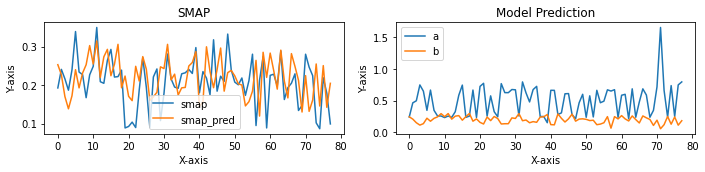

Epoch [24/5000] (LR: 0.0005):
Train loss: 0.0993 || Train physical loss: 0.0041 || Train similarity loss: 0.0951
Valid loss: 0.0046 || Valid physical loss: 0.0046 || Valid similarity loss: 0.0000


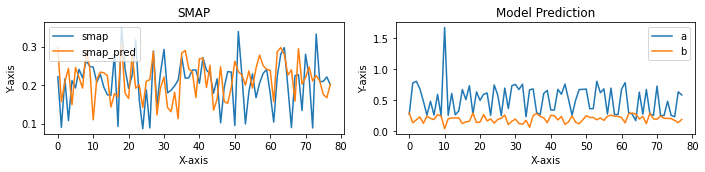

Epoch [25/5000] (LR: 0.0005):
Train loss: 0.0042 || Train physical loss: 0.0042 || Train similarity loss: 0.0000
Valid loss: 0.0044 || Valid physical loss: 0.0044 || Valid similarity loss: 0.0000


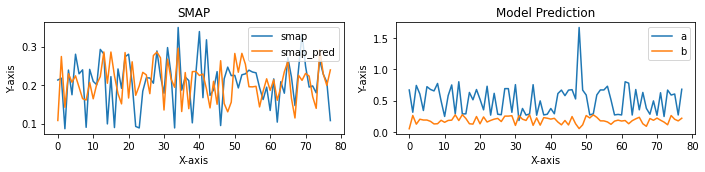

Epoch [26/5000] (LR: 0.0005):
Train loss: 0.0990 || Train physical loss: 0.0040 || Train similarity loss: 0.0950
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


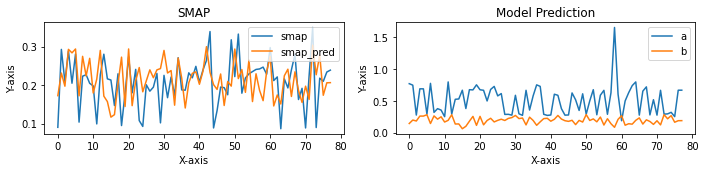

Epoch [27/5000] (LR: 0.0005):
Train loss: 0.0040 || Train physical loss: 0.0040 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


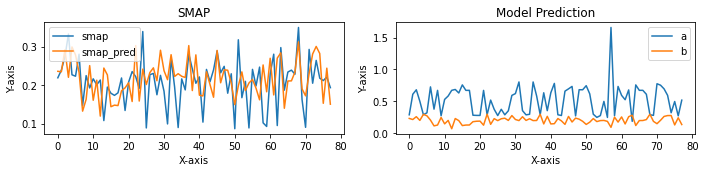

Epoch [28/5000] (LR: 0.0005):
Train loss: 0.0991 || Train physical loss: 0.0039 || Train similarity loss: 0.0952
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000


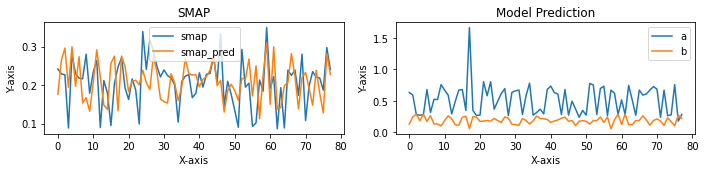

Epoch [29/5000] (LR: 0.0005):
Train loss: 0.0039 || Train physical loss: 0.0039 || Train similarity loss: 0.0000
Valid loss: 0.0042 || Valid physical loss: 0.0042 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


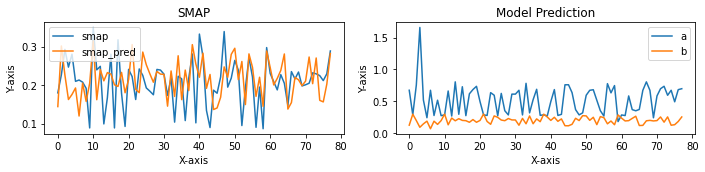

Epoch [30/5000] (LR: 0.0005):
Train loss: 0.0038 || Train physical loss: 0.0038 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


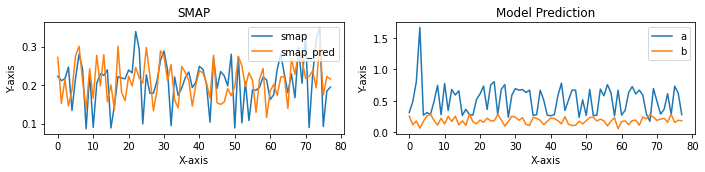

Epoch [31/5000] (LR: 0.0005):
Train loss: 0.0987 || Train physical loss: 0.0037 || Train similarity loss: 0.0950
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


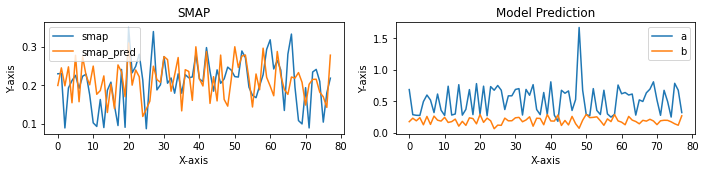

Epoch [32/5000] (LR: 0.0005):
Train loss: 0.0037 || Train physical loss: 0.0037 || Train similarity loss: 0.0000
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


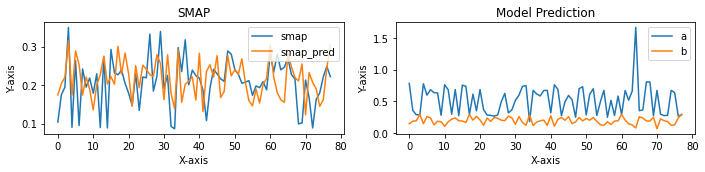

Epoch [33/5000] (LR: 0.0005):
Train loss: 0.0987 || Train physical loss: 0.0037 || Train similarity loss: 0.0950
Valid loss: 0.0040 || Valid physical loss: 0.0040 || Valid similarity loss: 0.0000


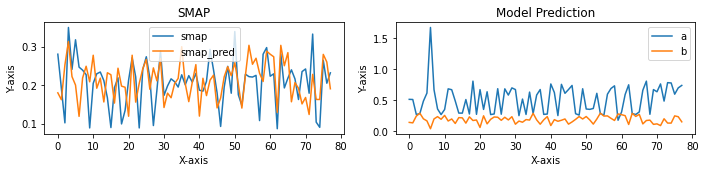

Epoch [34/5000] (LR: 0.0005):
Train loss: 0.0989 || Train physical loss: 0.0038 || Train similarity loss: 0.0951
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


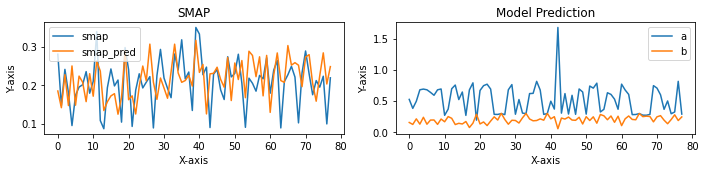

Epoch [35/5000] (LR: 0.0005):
Train loss: 0.0039 || Train physical loss: 0.0039 || Train similarity loss: 0.0000
Valid loss: 0.0041 || Valid physical loss: 0.0041 || Valid similarity loss: 0.0000


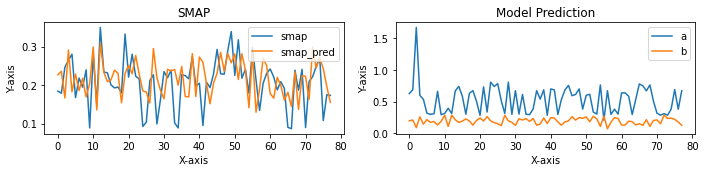

Epoch [36/5000] (LR: 0.0005):
Train loss: 0.0038 || Train physical loss: 0.0038 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


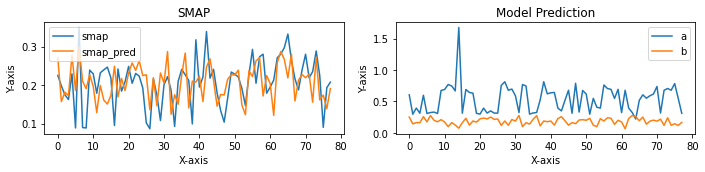

Epoch [37/5000] (LR: 0.0005):
Train loss: 0.0985 || Train physical loss: 0.0035 || Train similarity loss: 0.0950
Valid loss: 0.0037 || Valid physical loss: 0.0037 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


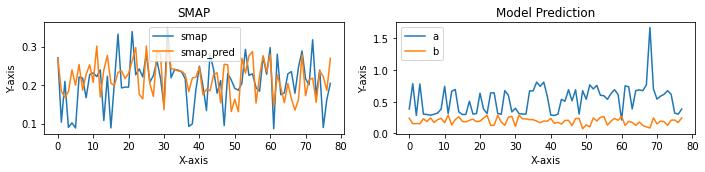

Epoch [38/5000] (LR: 0.0005):
Train loss: 0.0034 || Train physical loss: 0.0034 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


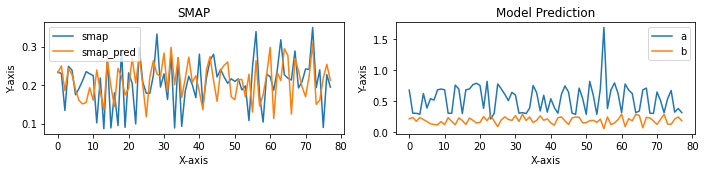

Epoch [39/5000] (LR: 0.0005):
Train loss: 0.0988 || Train physical loss: 0.0034 || Train similarity loss: 0.0954
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


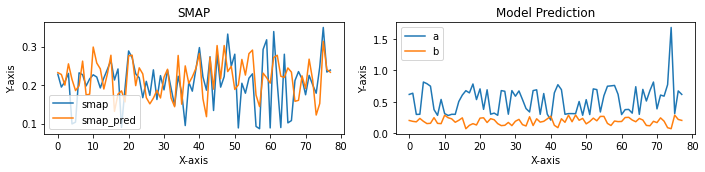

Epoch [40/5000] (LR: 0.0005):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


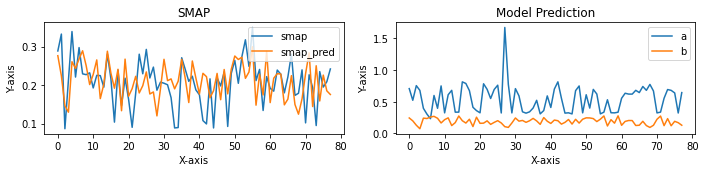

Epoch [41/5000] (LR: 0.0005):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0036 || Valid physical loss: 0.0036 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


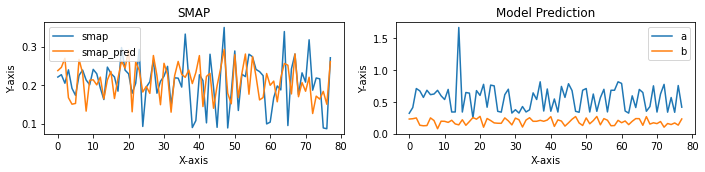

Epoch [42/5000] (LR: 0.0005):
Train loss: 0.0984 || Train physical loss: 0.0032 || Train similarity loss: 0.0952
Valid loss: 0.0036 || Valid physical loss: 0.0036 || Valid similarity loss: 0.0000
Saving model with loss 0.004...


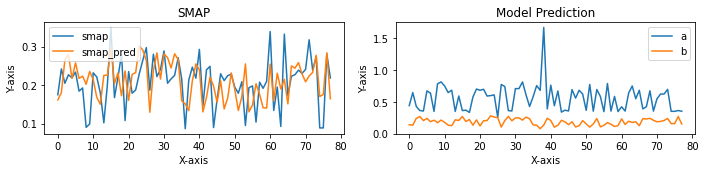

Epoch [43/5000] (LR: 0.0005):
Train loss: 0.0986 || Train physical loss: 0.0033 || Train similarity loss: 0.0953
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


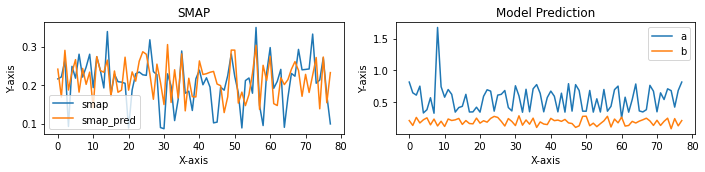

Epoch [44/5000] (LR: 0.0005):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0037 || Valid physical loss: 0.0037 || Valid similarity loss: 0.0000


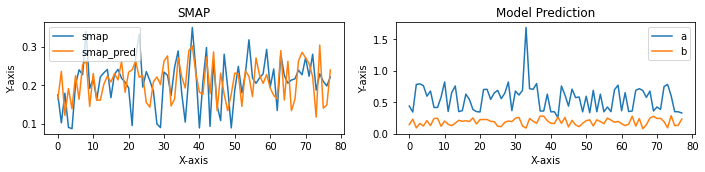

Epoch [45/5000] (LR: 0.0005):
Train loss: 0.0984 || Train physical loss: 0.0033 || Train similarity loss: 0.0951
Valid loss: 0.0037 || Valid physical loss: 0.0037 || Valid similarity loss: 0.0000


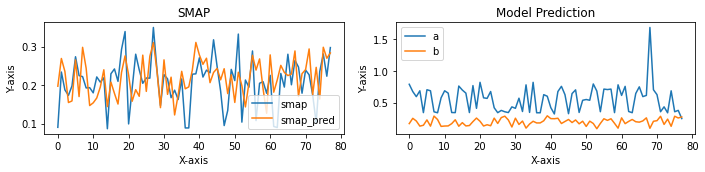

Epoch [46/5000] (LR: 0.0005):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


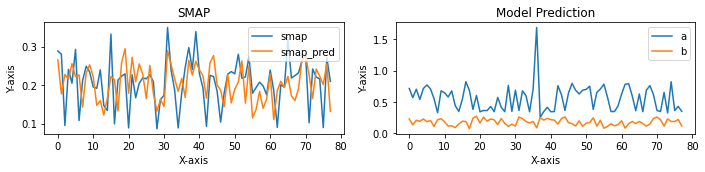

Epoch [47/5000] (LR: 0.0005):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0036 || Valid physical loss: 0.0036 || Valid similarity loss: 0.0000


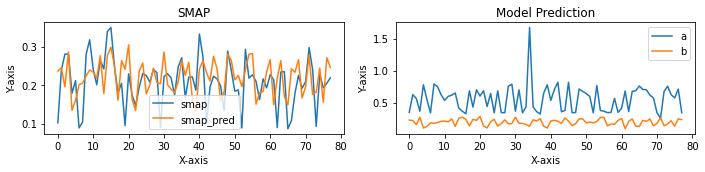

Epoch [48/5000] (LR: 0.0005):
Train loss: 0.0032 || Train physical loss: 0.0032 || Train similarity loss: 0.0000
Valid loss: 0.0036 || Valid physical loss: 0.0036 || Valid similarity loss: 0.0000


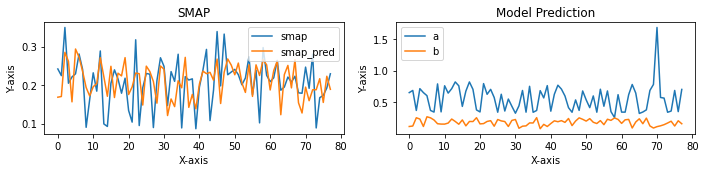

Epoch [49/5000] (LR: 0.0005):
Train loss: 0.0989 || Train physical loss: 0.0031 || Train similarity loss: 0.0958
Valid loss: 0.0034 || Valid physical loss: 0.0034 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


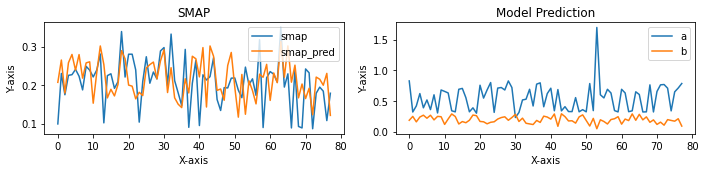

Epoch [50/5000] (LR: 0.0005):
Train loss: 0.1936 || Train physical loss: 0.0032 || Train similarity loss: 0.1905
Valid loss: 0.0037 || Valid physical loss: 0.0037 || Valid similarity loss: 0.0000


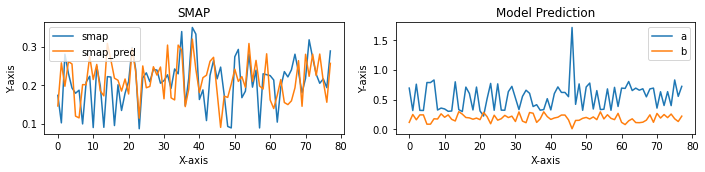

Epoch [51/5000] (LR: 0.0005):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0039 || Valid physical loss: 0.0039 || Valid similarity loss: 0.0000


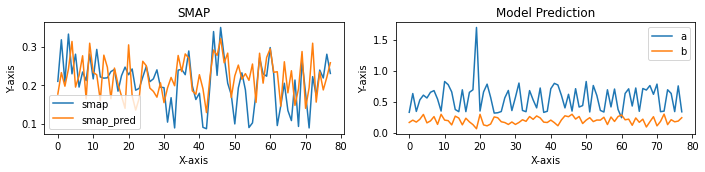

Epoch [52/5000] (LR: 0.0005):
Train loss: 0.0035 || Train physical loss: 0.0035 || Train similarity loss: 0.0000
Valid loss: 0.0038 || Valid physical loss: 0.0038 || Valid similarity loss: 0.0000


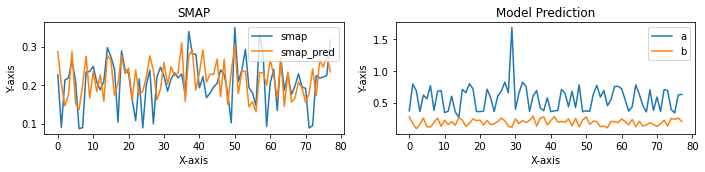

Epoch [53/5000] (LR: 0.0005):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0035 || Valid physical loss: 0.0035 || Valid similarity loss: 0.0000


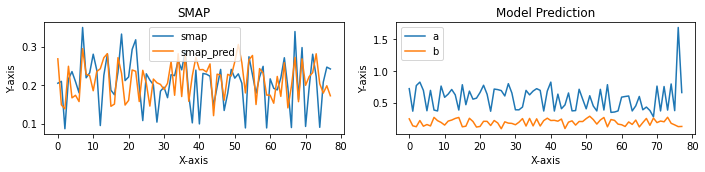

Epoch [54/5000] (LR: 0.0005):
Train loss: 0.0985 || Train physical loss: 0.0032 || Train similarity loss: 0.0953
Valid loss: 0.0035 || Valid physical loss: 0.0035 || Valid similarity loss: 0.0000


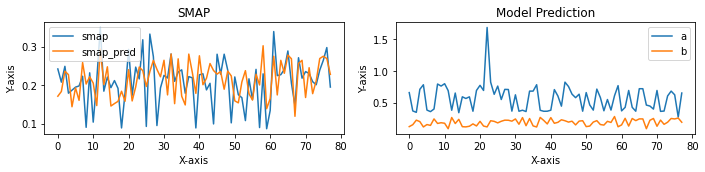

Epoch [55/5000] (LR: 0.0005):
Train loss: 0.0031 || Train physical loss: 0.0031 || Train similarity loss: 0.0000
Valid loss: 0.0034 || Valid physical loss: 0.0034 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


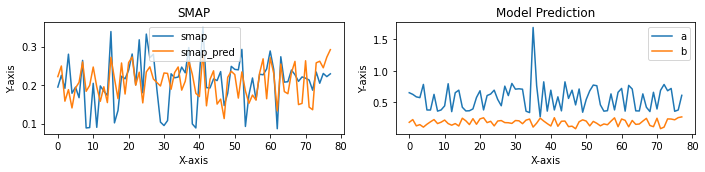

Epoch [56/5000] (LR: 0.0005):
Train loss: 0.0031 || Train physical loss: 0.0031 || Train similarity loss: 0.0000
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


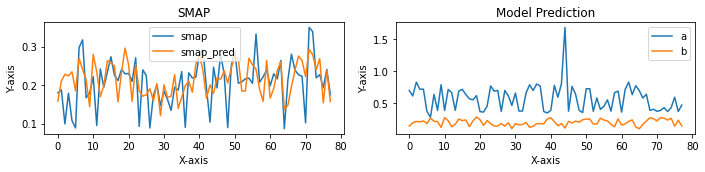

Epoch [57/5000] (LR: 0.0005):
Train loss: 0.0981 || Train physical loss: 0.0030 || Train similarity loss: 0.0950
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


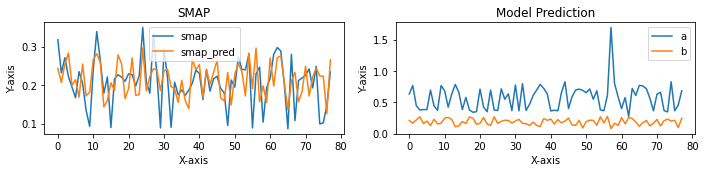

Epoch [58/5000] (LR: 0.0005):
Train loss: 0.0984 || Train physical loss: 0.0030 || Train similarity loss: 0.0954
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


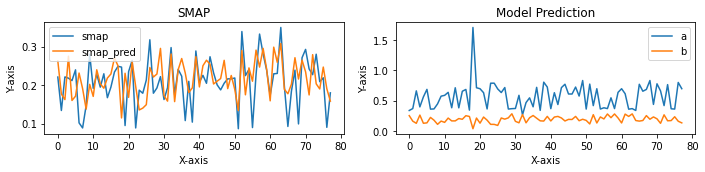

Epoch [59/5000] (LR: 0.0005):
Train loss: 0.0032 || Train physical loss: 0.0032 || Train similarity loss: 0.0000
Valid loss: 0.0034 || Valid physical loss: 0.0034 || Valid similarity loss: 0.0000


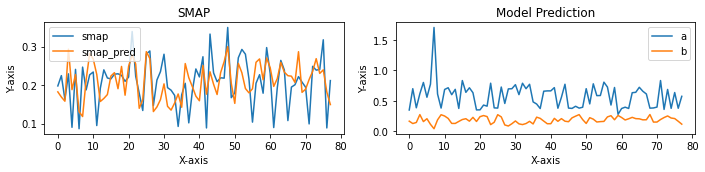

Epoch [60/5000] (LR: 0.0005):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


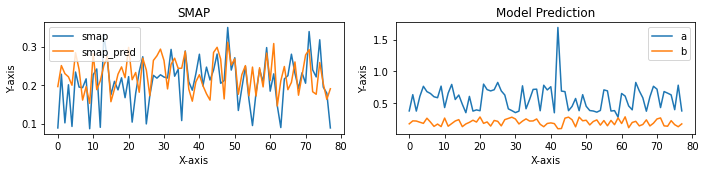

Epoch [61/5000] (LR: 0.0005):
Train loss: 0.0032 || Train physical loss: 0.0032 || Train similarity loss: 0.0000
Valid loss: 0.0034 || Valid physical loss: 0.0034 || Valid similarity loss: 0.0000


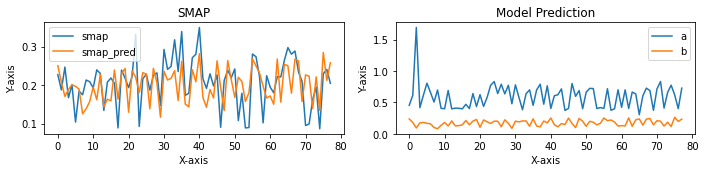

Epoch [62/5000] (LR: 0.0005):
Train loss: 0.0981 || Train physical loss: 0.0030 || Train similarity loss: 0.0952
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


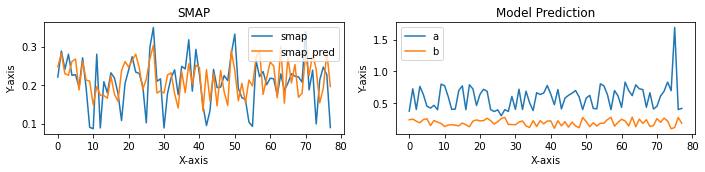

Epoch [63/5000] (LR: 0.0005):
Train loss: 0.0984 || Train physical loss: 0.0030 || Train similarity loss: 0.0954
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000


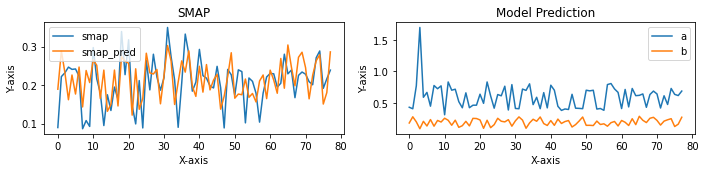

Epoch [64/5000] (LR: 0.0005):
Train loss: 0.0986 || Train physical loss: 0.0033 || Train similarity loss: 0.0953
Valid loss: 0.0034 || Valid physical loss: 0.0034 || Valid similarity loss: 0.0000


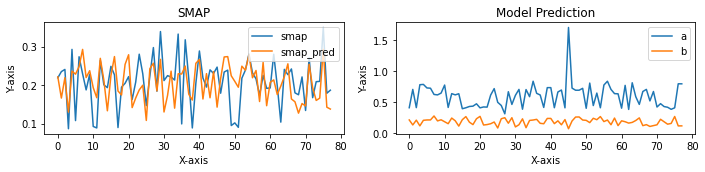

Epoch [65/5000] (LR: 0.0005):
Train loss: 0.0033 || Train physical loss: 0.0033 || Train similarity loss: 0.0000
Valid loss: 0.0033 || Valid physical loss: 0.0033 || Valid similarity loss: 0.0000


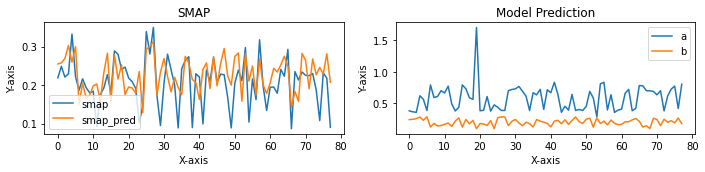

Epoch [66/5000] (LR: 0.0005):
Train loss: 0.0031 || Train physical loss: 0.0031 || Train similarity loss: 0.0000
Valid loss: 0.0035 || Valid physical loss: 0.0035 || Valid similarity loss: 0.0000


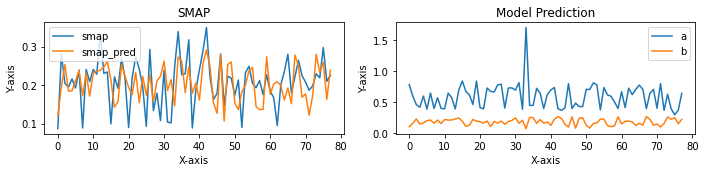

Epoch [67/5000] (LR: 0.0005):
Train loss: 0.0981 || Train physical loss: 0.0030 || Train similarity loss: 0.0951
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


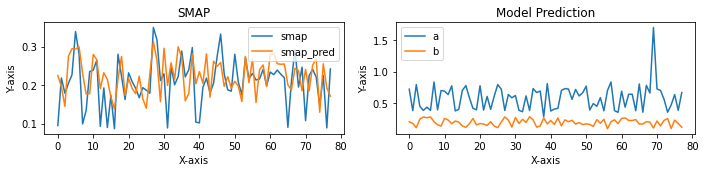

Epoch [68/5000] (LR: 0.0005):
Train loss: 0.0030 || Train physical loss: 0.0030 || Train similarity loss: 0.0000
Valid loss: 0.0033 || Valid physical loss: 0.0033 || Valid similarity loss: 0.0000


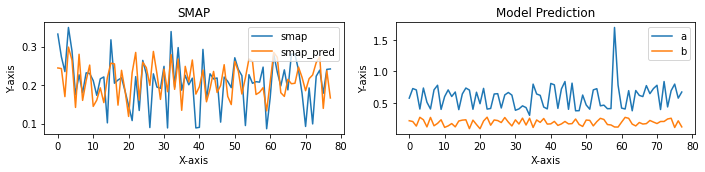

Epoch [69/5000] (LR: 0.0005):
Train loss: 0.0980 || Train physical loss: 0.0030 || Train similarity loss: 0.0951
Valid loss: 0.0031 || Valid physical loss: 0.0031 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


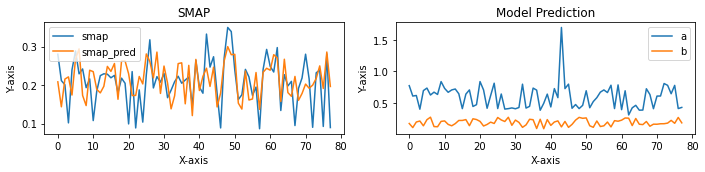

Epoch [70/5000] (LR: 0.0005):
Train loss: 0.0031 || Train physical loss: 0.0031 || Train similarity loss: 0.0000
Valid loss: 0.0031 || Valid physical loss: 0.0031 || Valid similarity loss: 0.0000


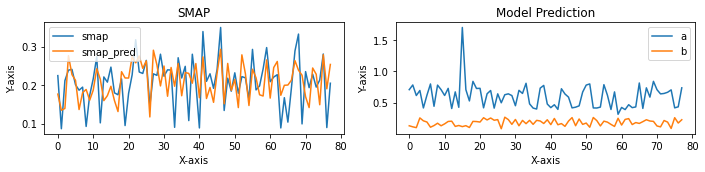

Epoch [71/5000] (LR: 0.0005):
Train loss: 0.0030 || Train physical loss: 0.0030 || Train similarity loss: 0.0000
Valid loss: 0.0030 || Valid physical loss: 0.0030 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


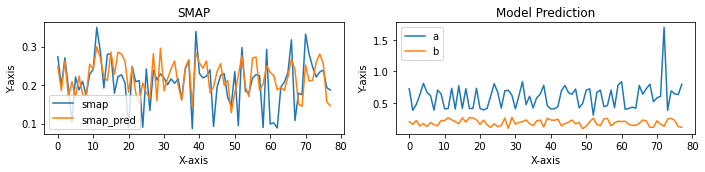

Epoch [72/5000] (LR: 0.0005):
Train loss: 0.0028 || Train physical loss: 0.0028 || Train similarity loss: 0.0000
Valid loss: 0.0031 || Valid physical loss: 0.0031 || Valid similarity loss: 0.0000


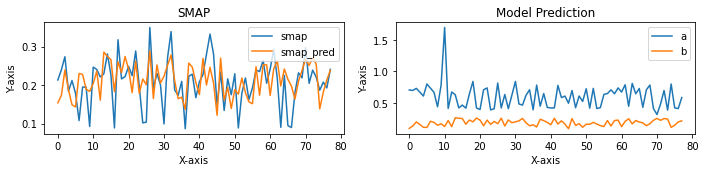

Epoch [73/5000] (LR: 0.0005):
Train loss: 0.0028 || Train physical loss: 0.0028 || Train similarity loss: 0.0000
Valid loss: 0.0029 || Valid physical loss: 0.0029 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


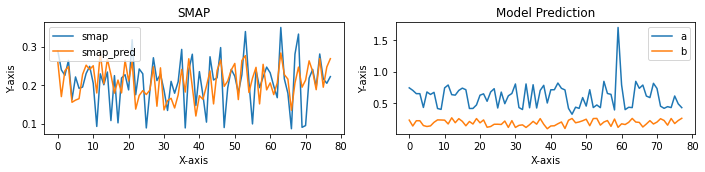

Epoch [74/5000] (LR: 0.0005):
Train loss: 0.0979 || Train physical loss: 0.0028 || Train similarity loss: 0.0951
Valid loss: 0.0029 || Valid physical loss: 0.0029 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


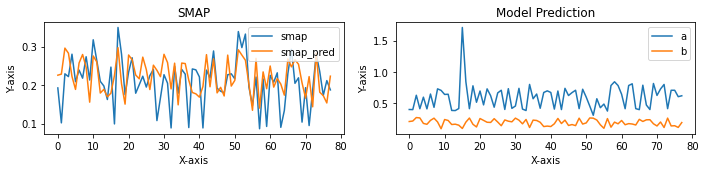

Epoch [75/5000] (LR: 0.0005):
Train loss: 0.0981 || Train physical loss: 0.0030 || Train similarity loss: 0.0951
Valid loss: 0.0031 || Valid physical loss: 0.0031 || Valid similarity loss: 0.0000


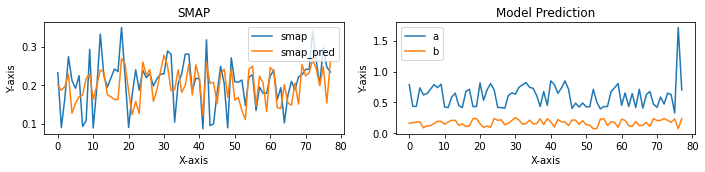

Epoch [76/5000] (LR: 0.0005):
Train loss: 0.0030 || Train physical loss: 0.0030 || Train similarity loss: 0.0000
Valid loss: 0.0031 || Valid physical loss: 0.0031 || Valid similarity loss: 0.0000


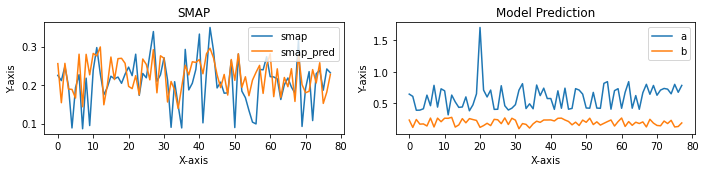

Epoch [77/5000] (LR: 0.0005):
Train loss: 0.0982 || Train physical loss: 0.0029 || Train similarity loss: 0.0953
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000


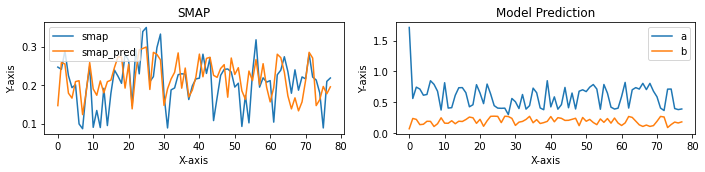

Epoch [78/5000] (LR: 0.0005):
Train loss: 0.0979 || Train physical loss: 0.0029 || Train similarity loss: 0.0950
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000


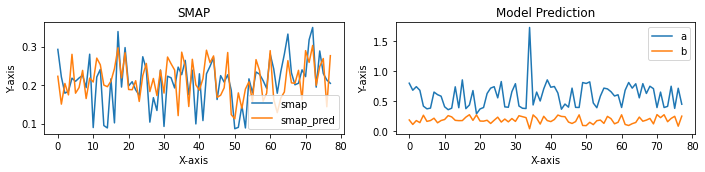

Epoch [79/5000] (LR: 0.0005):
Train loss: 0.0031 || Train physical loss: 0.0031 || Train similarity loss: 0.0000
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000


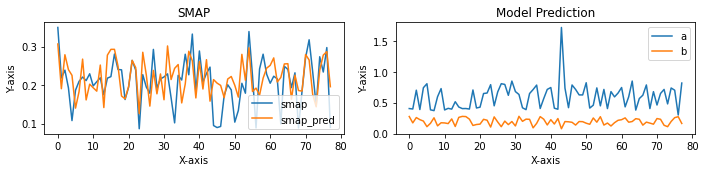

Epoch [80/5000] (LR: 0.0005):
Train loss: 0.0031 || Train physical loss: 0.0031 || Train similarity loss: 0.0000
Valid loss: 0.0032 || Valid physical loss: 0.0032 || Valid similarity loss: 0.0000


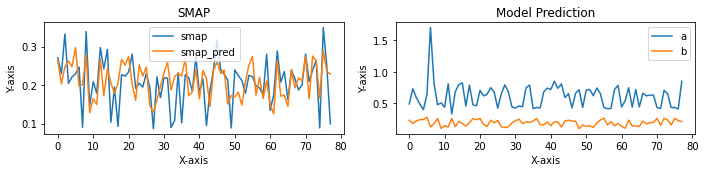

Epoch [81/5000] (LR: 0.0005):
Train loss: 0.0029 || Train physical loss: 0.0029 || Train similarity loss: 0.0000
Valid loss: 0.0030 || Valid physical loss: 0.0030 || Valid similarity loss: 0.0000


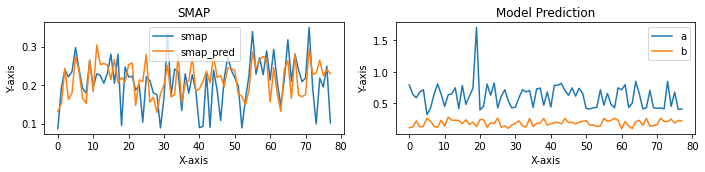

Epoch [82/5000] (LR: 0.0005):
Train loss: 0.0978 || Train physical loss: 0.0028 || Train similarity loss: 0.0950
Valid loss: 0.0030 || Valid physical loss: 0.0030 || Valid similarity loss: 0.0000


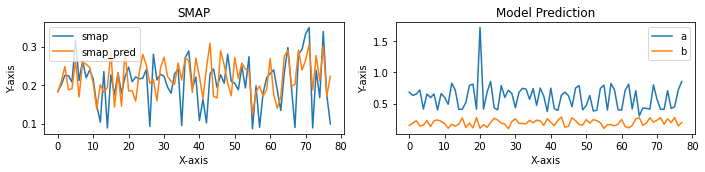

Epoch [83/5000] (LR: 0.0005):
Train loss: 0.0980 || Train physical loss: 0.0029 || Train similarity loss: 0.0951
Valid loss: 0.0031 || Valid physical loss: 0.0031 || Valid similarity loss: 0.0000


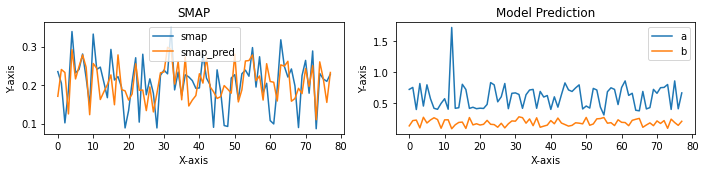

Epoch [84/5000] (LR: 0.0005):
Train loss: 0.0029 || Train physical loss: 0.0029 || Train similarity loss: 0.0000
Valid loss: 0.0030 || Valid physical loss: 0.0030 || Valid similarity loss: 0.0000


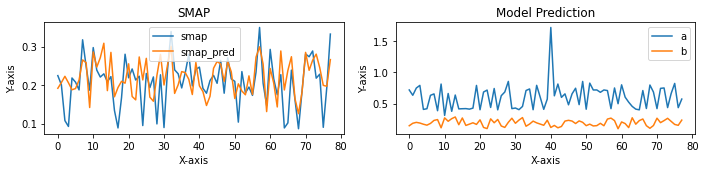

Epoch [85/5000] (LR: 0.0005):
Train loss: 0.0030 || Train physical loss: 0.0030 || Train similarity loss: 0.0000
Valid loss: 0.0030 || Valid physical loss: 0.0030 || Valid similarity loss: 0.0000


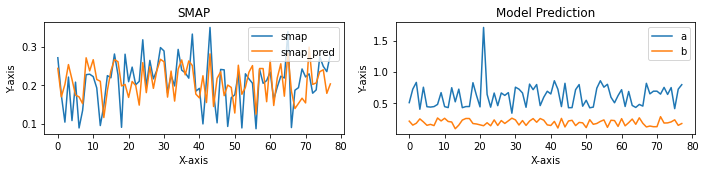

Epoch [86/5000] (LR: 0.0005):
Train loss: 0.0028 || Train physical loss: 0.0028 || Train similarity loss: 0.0000
Valid loss: 0.0028 || Valid physical loss: 0.0028 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


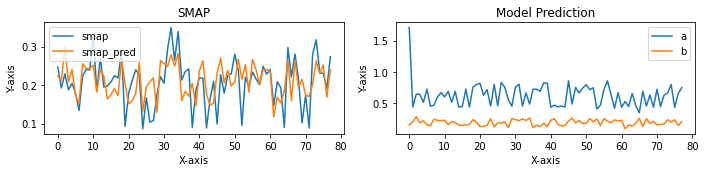

Epoch [87/5000] (LR: 0.0005):
Train loss: 0.0028 || Train physical loss: 0.0028 || Train similarity loss: 0.0000
Valid loss: 0.0028 || Valid physical loss: 0.0028 || Valid similarity loss: 0.0000
Saving model with loss 0.003...


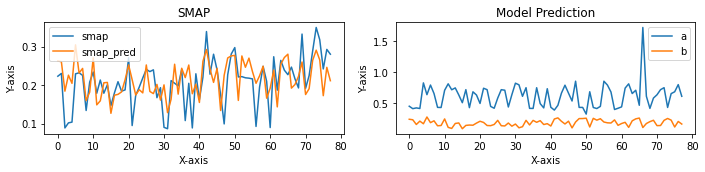

Epoch [88/5000] (LR: 0.0005):
Train loss: 0.1930 || Train physical loss: 0.0028 || Train similarity loss: 0.1902
Valid loss: 0.0029 || Valid physical loss: 0.0029 || Valid similarity loss: 0.0000


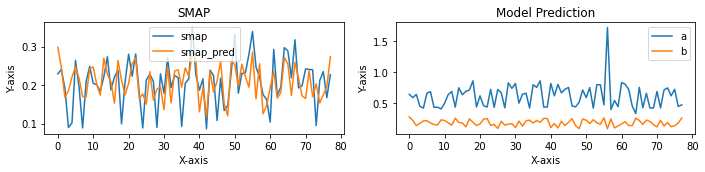

Epoch [89/5000] (LR: 0.0005):
Train loss: 0.0029 || Train physical loss: 0.0029 || Train similarity loss: 0.0000
Valid loss: 0.0028 || Valid physical loss: 0.0028 || Valid similarity loss: 0.0000


In [ ]:
# 创建模型保存目录
if os.path.exists(config['model_save_dir'])==False:
    os.makedirs(config['model_save_dir'], exist_ok=True)
    
if config['is_train']==True:
    print(dataset.get_input_shape(0))
    model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [ ]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = physics_loss
    model.eval()
    loss_record = []
    pred_list = np.zeros((len(test_loader), 2))
    for i, data_pkg in enumerate(test_loader):
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
            loss = criterion(pred, data_pkg['label_data'], 'Testing')
        loss_record.append(loss.item())
        pred_list[i][0] = pred[0][0]
        pred_list[i][1] = pred[0][1]
    mean_test_loss = sum(loss_record)/len(loss_record)
    print(mean_test_loss)
    print(pred_list)
#     print(loss_record)  
    return loss_record, pred_list

In [ ]:
param_path = os.path.join(config['root'],'OUTPUT\\MODELS\\CNN\\first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record, pred_list = tester(test_loader, model, config, device) 

In [ ]:
plt.plot(pred_list[:, 0], label='a')
plt.plot(pred_list[:, 1], label='b')
# 添加标题和标签
plt.title('Prediction of AB')
# plt.xlabel('Index of Model')
plt.legend()